# Legacy Sleep Wave Project Code

#### Initial Setup, Imports and Visuals

Using "Fpz-Cz"-- voltage difference bewteen electroide at center of forehead and top of head (this can be swapped to different electrodes)

Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_14684\1737552590.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw(psg_file, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_14684\1737552590.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw(psg_file, preload=True)


Using matplotlib as 2D backend.


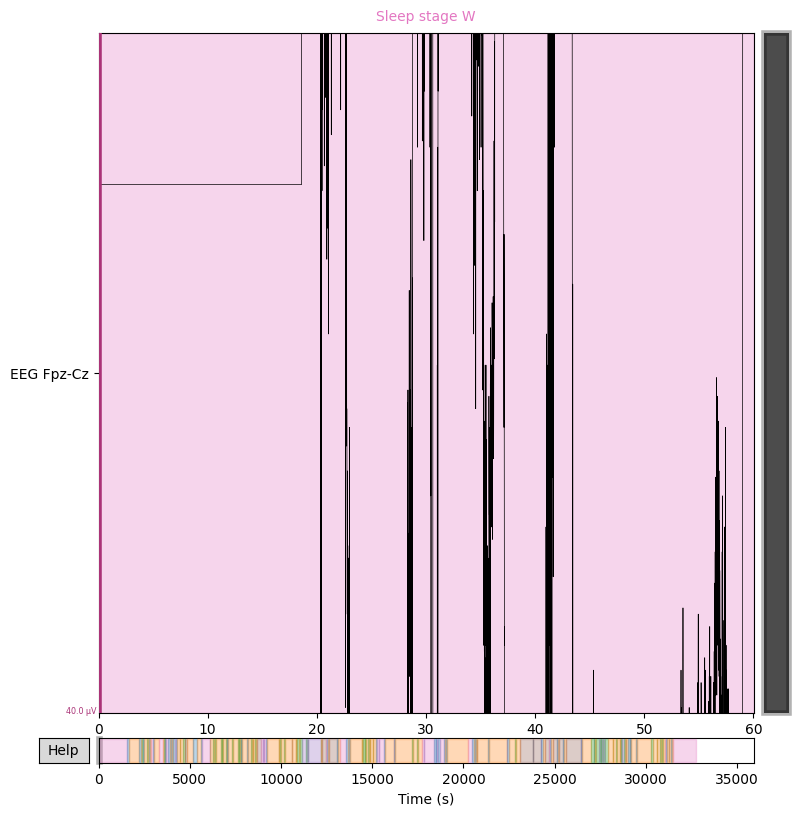

In [1]:
import numpy as np
import pandas as pd
import mne 
import matplotlib.pyplot as plt

psg_file = "../data/sleep_waves/ST7011J0-PSG.edf"
hypnogram = "../data/sleep_waves/ST7011JP-Hypnogram.edf"

# Loading new EEG data in
raw = mne.io.read_raw(psg_file, preload=True)
annotations = mne.read_annotations(hypnogram)
raw.set_annotations(annotations) 

# Focus on EEG channel: 
# Fpz-Cz -- voltage diff between electrode at forehead center and top of head
# One of two best for sleep data
raw.pick(['EEG Fpz-Cz'])

raw.plot(duration=60, n_channels=1, title='Raw EEG');

# The warnings that come up are not a concern: 

#### Preprocessing the Signal

EEG contains a huge range of freqs-- but sleep-related brain activity is concentrated in slow to moderate freqs. So by setting our limits to 0.5 - 40 Hz, we're filtering out all the non-sleep related (outside movement, muscle twitches, etc.)  

We're using "firwin" (Finite Impulse Response) because it's useful for isolating clean frequency bands

In [ ]:
raw.filter(0.5, 40., fir_design='firwin')

#### Segment into 30s Epochs (Sleep Scoring Standard)

30 second epochs have been the longstanding clinical and industry standard for measuring and classifying sleep-related brainwaves  

For clarity's sake, sleep stages do *not* change every second... they tend to last minutes at least. However, 30s windows are great for catching transitions between the stages with minimal lag  

**A thought**: if we encounter difficulty with classification, we could experiment with 60s window (would get more stable features)... BUT that runs the real risk of accidently mixing stages.

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 231 events and 3001 original time points ...
0 bad epochs dropped


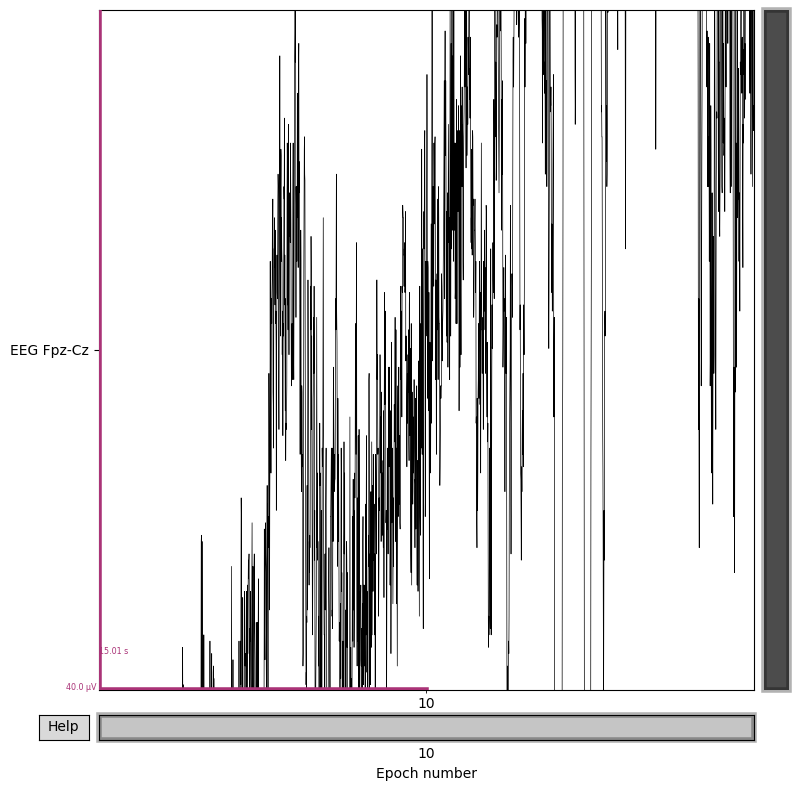

In [2]:
# Each annotation = 30s
# We'll match that in epoching for clarity's sake (industry standard)

events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=0, tmax=30, baseline=None, preload=True)


epochs[10].plot(title='Epoch 10: Raw EEG');

#### Extract Sleep Stage Labels

Mapping MNE annotations to the standard numeric sleep stages:

In [3]:
def extract_labels_from_events(events: np.ndarray, event_id: dict):
    '''
    Maps MNE event integer codes to standardized sleep labels 

    0: Wake
    1: N1
    2: N2
    3: N3 (includes Stage 4)
    4: REM

    Args: 
        events (np.ndarray): array of shape (n_epochs, 3) from MNE Epochs.events
        event_id (dict): Mapping from annotation strings to event codes
    '''

    reverse_event_map = {v: k for k, v in event_id.items()} 

    stage_map = {
        'Sleep stage W': 'Wake',
        'Sleep stage 1': 'N1',
        'Sleep stage 2': 'N2',
        'Sleep stage 3': 'N3',
        'Sleep stage 4': 'N3',  # Merged with Stage 3
        'Sleep stage R': 'REM'
    }
    
    labels = []
    for e in events: 
        raw_label = reverse_event_map.get(e[-1]) 
        if raw_label in stage_map: 
            labels.append(stage_map[raw_label])

        else: 
            # Dropping unknown / invalid labels
            labels.append(-1) 

    return labels


#### Feature Extraction (Band Power):

Computing avergae power in key freq bands per epoch

In [4]:
from mne.time_frequency import psd_array_welch

# Get raw epoch data as numpy array
epoch_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
sfreq = epochs.info['sfreq']    # typically 100 Hz for Sleep-EDF

# Compute Power Spectral Density
psds, freqs = psd_array_welch(epoch_data, sfreq=sfreq, fmin=0.5, fmax=40, n_fft=256)

def bandpower(psds: np.ndarray, freqs: np.ndarray, band: tuple): 
    ''' 
    Computes the mean power in a specific freq band for all epochs

    Args: 
        psds (np.array): Power spectral densities, shape (n_epochs, n_channels, n_freqs)
        freqs (np.ndarray): Array of freq values
        band (tuple): Lower and upper bounds of thr freq band (0.5-40Hz) 
    '''

    low, high = band
    idx = (freqs >= low) & (freqs <= high) 
    
    return psds[:, :, idx].mean(axis=-1).mean(axis=1) 


Effective window size : 2.560 (s)


In [5]:
features = pd.DataFrame({
    'delta': bandpower(psds, freqs, (0.5, 4)), 
    'theta': bandpower(psds, freqs, (4, 8)), 
    'alpha': bandpower(psds, freqs, (8, 13)), 
    'beta': bandpower(psds, freqs, (13, 30))
})

labels = extract_labels_from_events(epochs.events, event_id)
features['label'] = labels
features = features[features['label'] != -1]
features

,delta,theta,alpha,beta,label
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake
1,6.851487e-12,2.188516e-12,1.104633e-12,8.372303e-13,N1
2,2.707088e-11,3.864857e-12,1.452854e-12,8.678398e-13,N2
3,2.403117e-11,1.126442e-12,1.835699e-12,5.003665e-13,N1
4,4.395439e-11,2.545034e-12,1.276473e-12,8.361875e-13,N2
...,...,...,...,...,...
226,1.094986e-11,5.340083e-12,2.876573e-12,6.202583e-13,N1
227,2.990901e-11,3.682701e-12,1.535844e-12,4.703400e-13,N2
228,8.224605e-12,8.211704e-13,1.131959e-12,2.921567e-13,N1
229,3.505815e-11,4.377674e-12,1.748958e-12,5.864489e-13,N2


### Data Augmentation, Not Rollback
April 12th, 2025

Since smushing together ~41 eeg and hypnogram pairs (for the purpose of a large enough training sample), I've realized that this many different Cycles (complicated by Cycle 1 != Cycle 2) are present, and all mashed together as if it's 6000 hours of constant sleep.  
  
However, it makes sense why I had to do it. Now, in order to preserve the **temporal structure**, we're going to: 
1) Track sleep cycles explicitly
2) Add a `cycle_number` feature 
3) Test HMM-Smoothing on a per-night and per-cycle basis

If none of these options work, RNN or a Temportal CNN might be a better fit for the nature of our data.

### Legacy Cycle Segmentation 
- Wake --> N1 or N2 (start of sleep)
- REM --> Wake (likely end of cycle)
- Duration > 220 epochs (110 mins) 

Assigning a `cycle` column. Resets to 0 for each subject, allowing for easier cycle tracking.

In [ ]:
def segment_subject_cycles(df: pd.DataFrame, min_cycle_len=60, max_cycle_len=140, min_rem_epochs=4): 
    '''
    Segments sleep data into cycles per subject, based on sleep stage transitions
    Assumes 30s epochs. Each cycle is marked after a qualifying REM streak

    Args: 
        df: EEG data-- requires 'label' and 'subject_id' col 
        min_cycle_len (int): min expected cycle length (60 mins)
        max_cycle_len (int): max expected cycle length (120 mins)
        min_rem_epochs (int): min number of REM epochs to consider a valid REM phase

    Returns: 
        df: original df with added 'cycle' column, segmented per subject
    '''

    df = df.copy()
    all_segmented = []

    # Epoch = 30s 
    min_len = (min_cycle_len * 2) 
    max_len = (max_cycle_len * 2) 

    for subject_id, subject_df in df.groupby('subject_id'): 
        labels = subject_df['label'].values
        cycle_col = np.zeros(len(labels), dtype=int) 

        cycle = 0 
        last_idx = 0 
        rem_streak = 0
        rem_end_idx = None

        for i in range(1, len(labels)): 
            cycle_col[i] = cycle

            if labels[i] == 'REM': 
                rem_streak += 1
                rem_end_idx = i # Update while REM continues!
            else: 
                if rem_streak >= min_rem_epochs and rem_end_idx is not None:
                    span = np.sum(~np.isin(labels[last_idx:rem_end_idx + 1], ['Wake', 'UNKNOWN']))
                    if min_len <= span <= max_len: 
                        cycle += 1 
                        last_idx = rem_end_idx + 1 # Start next cycle after REM block!
                rem_streak = 0 
                rem_end_idx = None

        subject_df = subject_df.copy()
        subject_df['cycle'] = cycle_col 
        all_segmented.append(subject_df) 

    return pd.concat(all_segmented, ignore_index=True) 

## Legacy Feature Engineering

### New Features: Temporal Context (`delta_t-1`, `theta_t-1`, ... `beta_t+1`)
NOTE: DID NOT WORK, as in-- made the entire model **break**!
  
However, I'm preserving the effort for potential later use!

In [ ]:
def add_temporal_context(df: pd.DataFrame, feature_cols: list, shifts=[-1, 1]): 
    '''
    Add temporal context features by shifting original feature cols within each subject group

    Params: 
        df (pd.DataFrame): df with 'subject_id'
        feature_cols (list): List of features to shift
        shifts (list): Epoch shifts to apply (ex. [-1,1] for t-1 and t+1) 

    Returns: 
        df (pd.DataFrame): df with added shifted feature columns 
    '''

    df = df.copy()
    
    for shift in shifts:
        shifted = (
            df.groupby('subject_id')[feature_cols]
            .shift(shift)
            .rename(columns=lambda col: f'{col}_t{shift:+}') # Shifted col names
        )
        df = pd.concat([df, shifted], axis=1)
    
    return df.dropna() # Drop rows with NaN values (due to shifts)

In [ ]:
feat_cols = ['delta', 'theta', 'alpha', 'beta'] 
df_edf = add_temporal_context(df_edf, feat_cols, shifts=[-1,1]) 

df_edf